In [1]:
import json
import pandas as pd
import numpy as np
import PySAM.Pvwattsv8 as PVWatts
import PySAM.Grid as Grid
import csv
import os
import geopandas as gpd
import math
import shutil 
from tqdm import tqdm


In [3]:
def create_output_folder(directory, deleteFolder = False):
    if not(os.path.isdir(directory)):
        os.makedirs(directory)
    else:
        if(deleteFolder):
            shutil.rmtree(directory)
            os.makedirs(directory)

def loadModules(file_names):
    pv = PVWatts.new()
    grid = Grid.from_existing(pv)

    with open(file_names[0], 'r') as file:
        data = json.load(file)
        for k, v in data.items():
                pv.value(k, v)

    with open(file_names[1], 'r') as file:
        data = json.load(file)
        for k, v in data.items():
                grid.value(k, v)

    return pv, grid

def get_matrix(tilts):
    tilts = tilts.round()
    angles = np.unique(tilts)
    azimuths = np.arange(0, 360, 1)

    matrix = []
    singleRow = []
    singleRow.append(0)
    for angle in azimuths:
        singleRow.append(angle)

    matrix.append(singleRow)
    for i, angle in enumerate(angles):
        singleRow = []
        singleRow.append(angle)
        for j, tilt in enumerate(tilts):
            if angle <= tilt:
                singleRow.append(100)
            else:
                singleRow.append(0)
        matrix.append(singleRow)
    return matrix

def getInfoRoof(plane):
    tilt = plane.tilt.values[0]
    azimuth = plane.azimuth.values[0]
    area = plane.area.values[0]/math.cos(tilt*math.pi/180)
    return  area, tilt, azimuth


def runPySAMSimulation(file_names, tilts, plane, panel, tmyfile, returnType=None):
    pv, grid = loadModules(file_names)
    shadingMatrix = get_matrix(tilts)

    area, tilt, azimuth = getInfoRoof(plane)
    
    ratio=0.400/(1.879*1.045)

    modifiedParams = {"shading_azal": shadingMatrix,
        "system_capacity": area*ratio, #*self.pv.value("gcr"), #We don't need the area by the ground coverage ratio
        "tilt": tilt,
        "azimuth": azimuth,
        "solar_resource_file": tmyfile}

    for i in range(len(modifiedParams)): 
        pv.value(list(modifiedParams.keys())[i], list(modifiedParams.values())[i])

    modules = [pv, grid]
    
    for m in modules:
        m.execute()

    if(returnType=="AC"):
        generation = pv.export()["Outputs"]["ac"]
        generation = np.array(generation).reshape(365, 24)
        generation_df = pd.DataFrame(generation)
        generation_df = generation_df/area
        annual_ac = generation_df.sum().sum() 
        return annual_ac
    elif(returnType=="POA"):
        return sum(pv.export()["Outputs"]["poa_monthly"])
    else:
        return pv.export()["Outputs"]

In [5]:
file_names = ["/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Scripts/sunEstimation/pysam_template_pvwattsv8.json",
    "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Scripts/sunEstimation/pysam_template_grid.json"]

tmyfile = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/RAW_Data/TMY/NREL/419806_41.41_2.22_tmy-2022.csv"

basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

# plane = planesGDF[planesGDF.cluster == cluster]
# export = runPySAMSimulation(file_names, tilts, plane, panel, tmyfile)

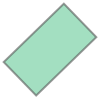

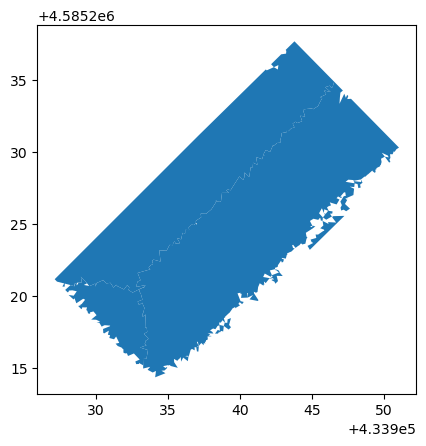

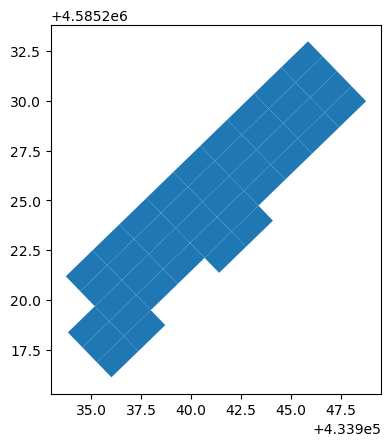

In [25]:
planeFile = basePath + "Results/Test_70_el Besòs i el Maresme/Parcels/4054901DF3845C/408/Plane Identification/408.gpkg"
planeGDF = gpd.read_file(planeFile)
planeGDF.plot()

panelsFile = basePath + "Results/Test_70_el Besòs i el Maresme/Parcels/4054901DF3845C/408/Solar Estimation Panels/1.gpkg"
panelsGDF = gpd.read_file(panelsFile)
panelsGDF.plot()
panel = panelsGDF.iloc[0]
panel.geometry


In [34]:
x, y = panel.geometry.exterior.coords.xy
x, y

(array('d', [433944.50821089745, 433945.2358186762, 433946.58451742446, 433945.8569096457, 433944.50821089745]),
 array('d', [4585231.66249935, 4585230.912424739, 4585232.22072619, 4585232.9708008, 4585231.66249935]))

In [ ]:
# Get 
